# Objective

To analyse how external factors influence fresh fruit bunch (FFB) yield.

# Setting up the Workspace

## Importing libraries

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

## Reading in the data

In [26]:
DATA = "PreScreen_r3\palm_ffb.csv"
ffb = pd.read_csv(DATA)
ffb.head()

,Date,SoilMoisture,Average_Temp,Min_Temp,Max_Temp,Precipitation,Working_days,HA_Harvested,FFB_Yield
0,01.01.2008,616.4,25.306452,21.3,32.2,184.4,25,777778.3951,1.62
1,01.02.2008,568.9,26.165517,20.9,35.1,140.2,23,767988.2759,1.45
2,01.03.2008,577.6,25.448387,21.3,32.9,280.4,25,783951.9231,1.56
3,01.04.2008,581.1,26.903333,20.6,34.8,173.3,25,788987.0504,1.39
4,01.05.2008,545.4,27.241935,20.9,35.0,140.6,25,813659.7222,1.44


In [27]:
ffb["Date"] = pd.to_datetime(ffb["Date"], format="%d.%m.%Y")

In [4]:
print(f"The data spans from {min(ffb['Date'])} to {max(ffb['Date'])}.")

The data spans from 2008-01-01 00:00:00 to 2018-10-01 00:00:00.


In [5]:
ffb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           130 non-null    datetime64[ns]
 1   SoilMoisture   130 non-null    float64       
 2   Average_Temp   130 non-null    float64       
 3   Min_Temp       130 non-null    float64       
 4   Max_Temp       130 non-null    float64       
 5   Precipitation  130 non-null    float64       
 6   Working_days   130 non-null    int64         
 7   HA_Harvested   130 non-null    float64       
 8   FFB_Yield      130 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 9.3 KB


There are no missing data.

# Does the FFB yield fluctuate?

In [29]:
ffb["month"] = ffb["Date"].dt.month
ffb["year"] = ffb["Date"].dt.year

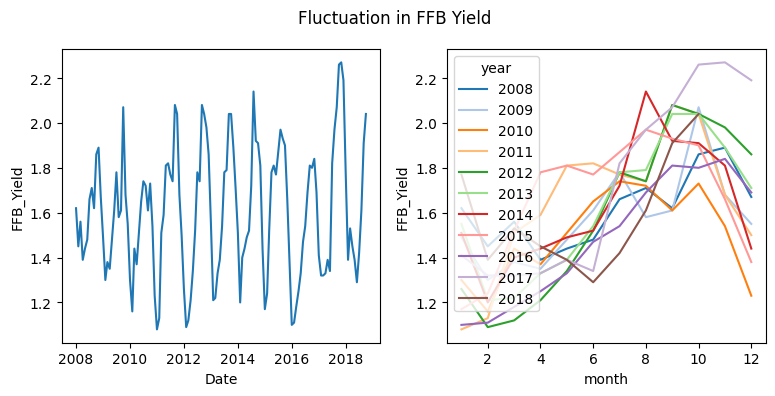

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle("Fluctuation in FFB Yield")
sns.lineplot(data=ffb, x="Date", y="FFB_Yield", ax=ax[0])

sns.lineplot(data=ffb, x="month", y="FFB_Yield", hue="year", ax=ax[1], palette=sns.color_palette('tab20', 11))

fig.tight_layout()

<AxesSubplot:xlabel='year', ylabel='FFB_Yield'>

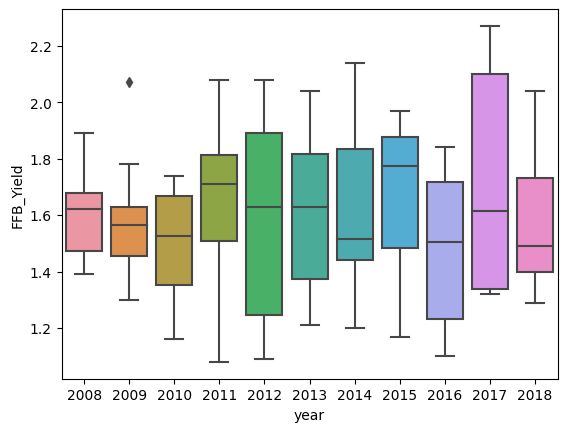

In [31]:
sns.boxplot(data=ffb, x="year", y="FFB_Yield")

There are fluctuations in the yield not only between years but also within each year.

While the fluctuatuions between yield can be attributed to new technology, we will only be considering the effects of external factors.

<AxesSubplot:xlabel='month', ylabel='FFB_Yield'>

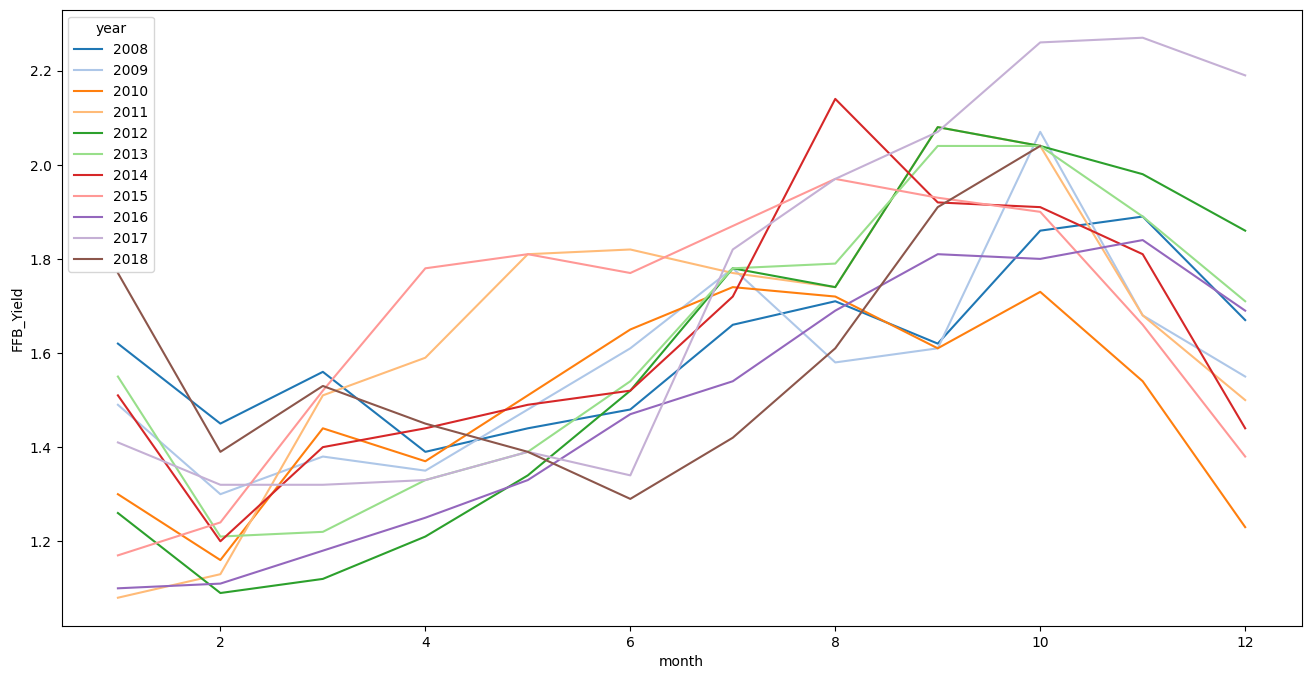

In [9]:
fig, ax =plt.subplots(figsize=(16, 8))
sns.lineplot(data=ffb, x="month", y="FFB_Yield", hue="year", palette=sns.color_palette('tab20', 11))

Yield is typically lower during the end/start of the year and increases as the year progresses.

Februrary consistently has low yield whereas October consistently has high yield.

# How does February and October differ from the rest of the months?

In [10]:
ffb_feb = ffb[ffb["month"] == 2]
ffb_oct = ffb[ffb["month"] == 10]
ffb_remaining = ffb[~ffb["month"].isin([2, 10])]

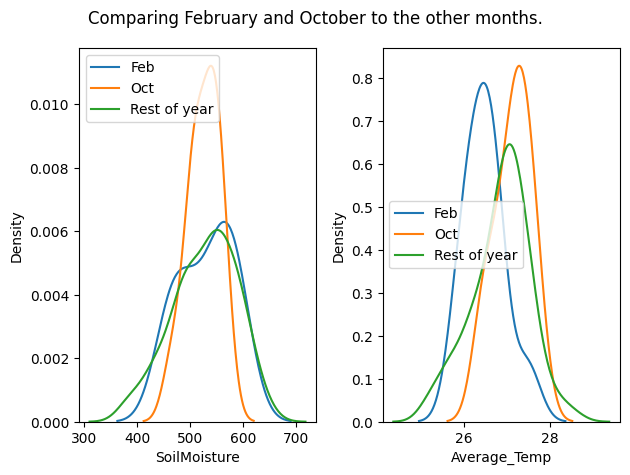

In [13]:
fig, ax = plt.subplots(1, 2)
fig.suptitle("Comparing February and October to the other months.")

sns.kdeplot(ffb_feb["SoilMoisture"], label="Feb", ax=ax[0])
sns.kdeplot(ffb_oct["SoilMoisture"], label="Oct", ax=ax[0])
sns.kdeplot(ffb_remaining["SoilMoisture"], label="Rest of year", ax=ax[0])
ax[0].legend()

sns.kdeplot(ffb_feb["Average_Temp"], label="Feb", ax=ax[1])
sns.kdeplot(ffb_oct["Average_Temp"], label="Oct", ax=ax[1])
sns.kdeplot(ffb_remaining["Average_Temp"], label="Rest of year", ax=ax[1])
ax[1].legend()

fig.tight_layout()

**Findings**
1. October seems to be in a sweet spot: good soil moisture and productive temperatures.
2. February has similar soil moisture to October but crucially experiences **lower temperatures which seem to adversely affect the FFB yield**.

# Correlation analysis

I am dropping the following columns as we are only interested in the effects of external factors on the yield:
- date
- month
- year
- working days
- hectares harvested

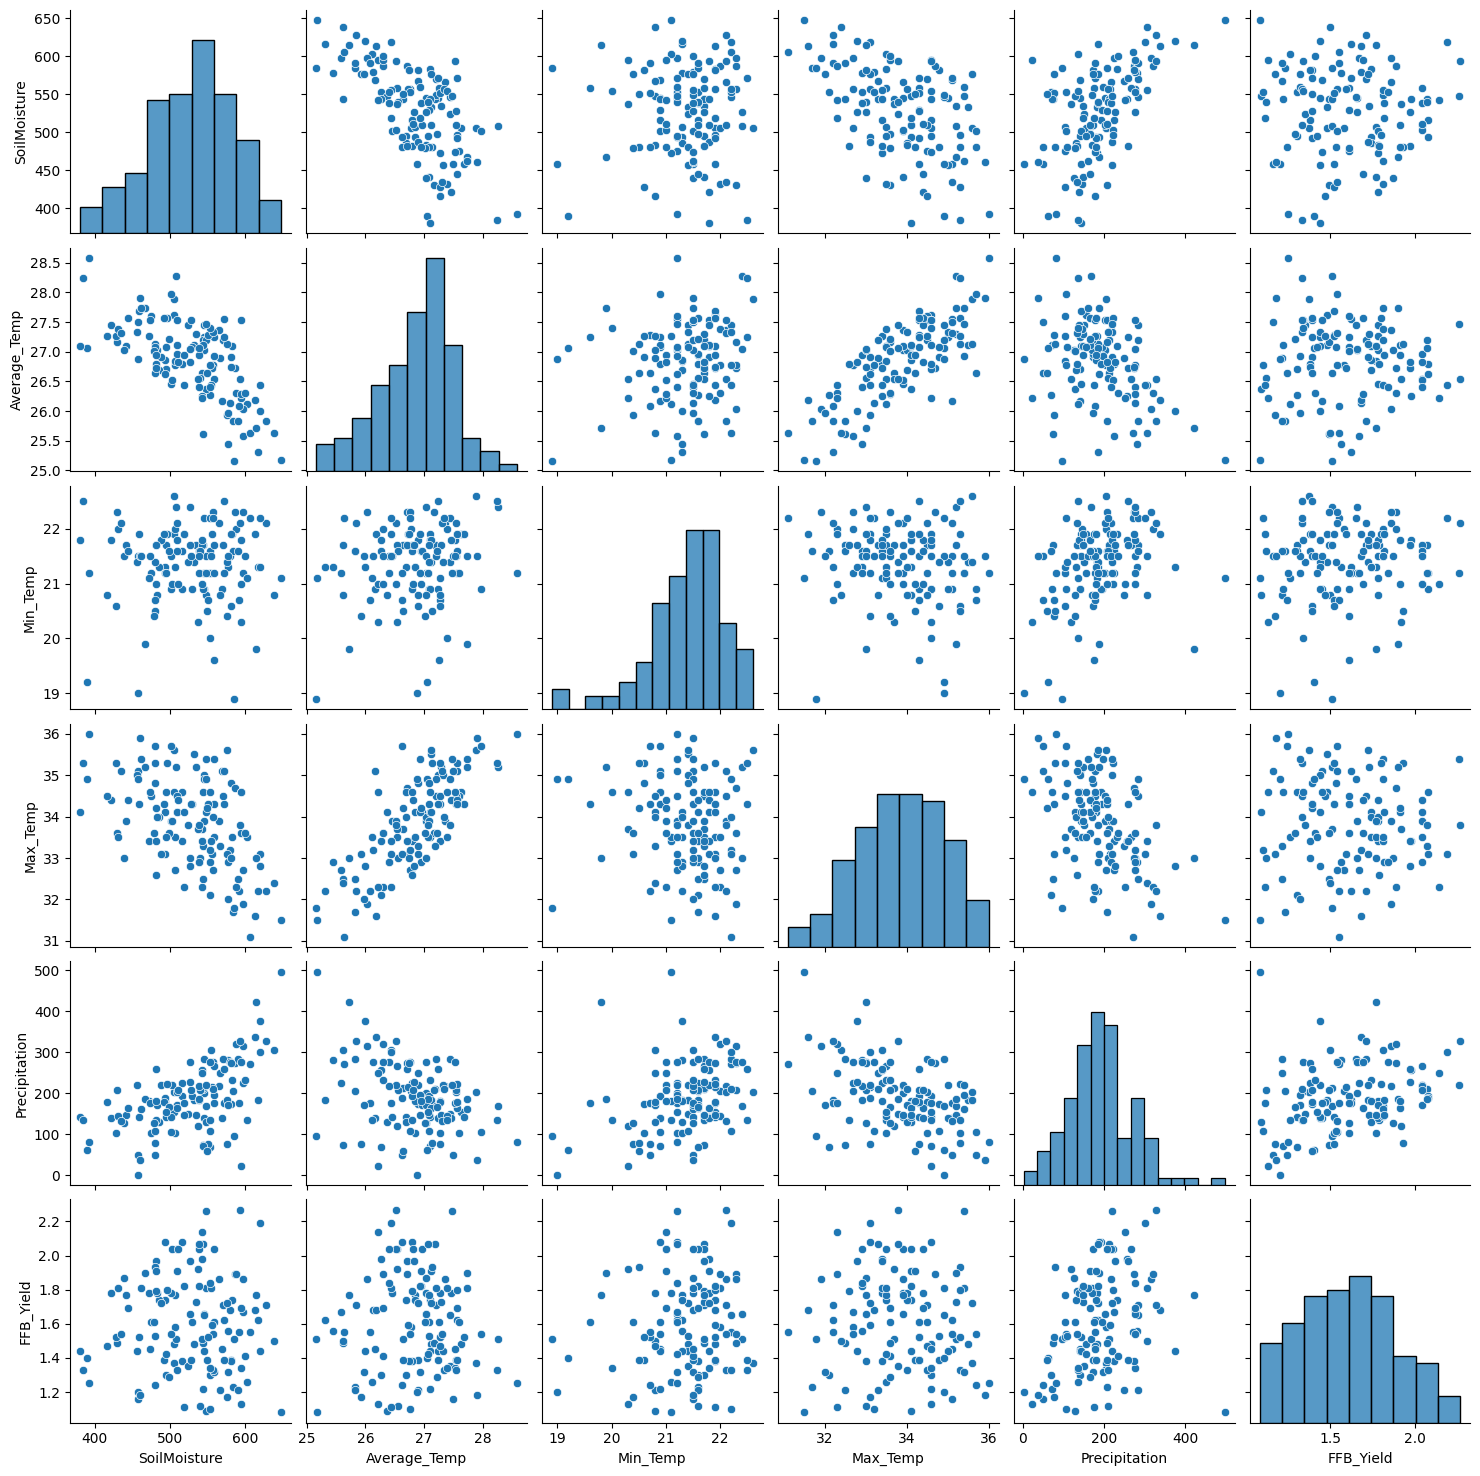

In [14]:
ffb.drop(columns=["Date", "month", "year", "Working_days", "HA_Harvested"], inplace=True)
sns.pairplot(ffb)

<AxesSubplot:>

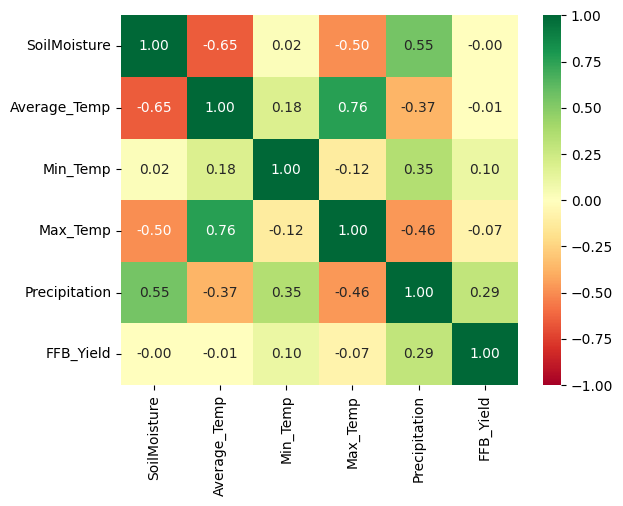

In [15]:
sns.heatmap(ffb.corr(), annot=True, fmt=".2f", vmin=-1, vmax=1, cmap='RdYlGn')

The following features have strong correlation (as expected):
- Soil moisture and precipitation.
- Soil moisture and average temperature (negative correlation).
- Average temperature and maximum temperature.

# Feature Engineering

It can be observed from the scatterplots that yield is low when precipitation is too high. We can create a feature to capture this information.

In [16]:
precip_q1 = ffb["Precipitation"].quantile(0.25)
precip_q3 = ffb["Precipitation"].quantile(0.75)
precip_iqr = precip_q3 - precip_q1
precip_limit = precip_q3 + (1.5 * precip_iqr)
ffb["overprecipitation"] = np.where(ffb["Precipitation"] > precip_limit, 1, 0)

<AxesSubplot:>

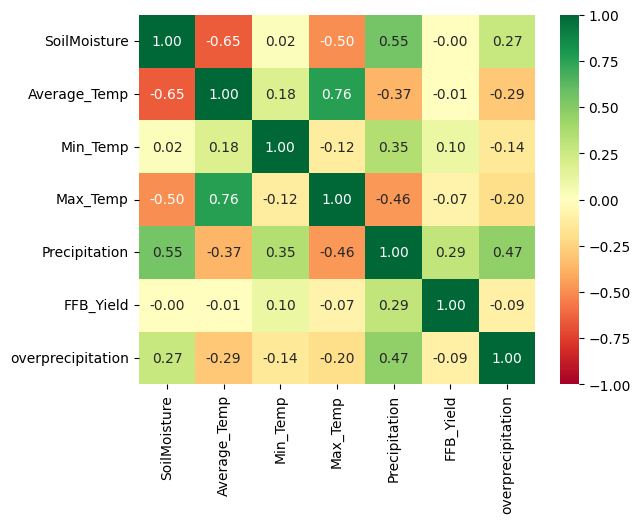

In [17]:
sns.heatmap(ffb.corr(), annot=True, fmt=".2f", vmin=-1, vmax=1, cmap='RdYlGn')

# Using machine learning algorithms to find feature weightage/importance

Since the aim is to understand the feature importance, I won't spend time on hyperparameter turning and will use the default parameters for each algorithm.

In [18]:
X = ffb[[col for col in ffb.columns if col not in ["FFB_Yield"]]]
y = ffb["FFB_Yield"]

## Linear Regression

We will scale the data so that the weightage assigned to each feature are comparable.

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

lm = LinearRegression().fit(X_scaled, y)
r_squared = lm.score(X_scaled, y)
print(f"Linear regression's coefficient of determination: {r_squared}")
print(f"Intercept: {lm.intercept_}")
print(f"Coefficients: {lm.coef_}")

Linear regression's coefficient of determination: 0.21020829330417068
Intercept: 1.6022307692307693
Coefficients: [-0.08076505 -0.01353405 -0.04569029  0.01075608  0.18868056 -0.10108546]


Even though the R2 is low, the highest weightage is given to precipitation (5th feature).

## Random Forest

In [23]:
rfr = RandomForestRegressor(random_state=23)
rfr.fit(X, y)
r_squared = rfr.score(X, y)
print(f"Random Forest's coefficient of determination: {r_squared}")

Random Forest's coefficient of determination: 0.875872625903196


In [24]:
rfr.feature_importances_

array([0.18652411, 0.2483711 , 0.12112073, 0.10699116, 0.33601854,
       0.00097436])

Random Forest also assigns the highest importance to precipitation followed by average temperature.

# Conclusion

1. FFB yield is definitely affected by external factors, especially precipitation and average temperature.
2. There appears to be a sweet spot for maximum FFB yield; temperature should not be too low and precipitation should not be too high.
3. Februrary consistenly low yields due the month having low temperatures. October consistenly has high yields as it is in the sweet spot.
